In [1]:
# downloaded from https://grouplens.org/datasets/movielens/25m/

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import time
from tqdm.auto import tqdm

dbg = True
# from google.colab import drive
# drive.mount('/content/gdrive')
nrows = {True:100000, False:None}[dbg]
rating_df = pd.read_csv('ml-25m/ratings.csv', nrows=nrows)
tag_df = pd.read_csv('ml-25m/tags.csv', nrows=nrows)
movie_df = pd.read_csv('ml-25m/movies.csv')
rating_df['userId'] = rating_df['userId'] - 1
rating_df['movieId'] = rating_df['movieId'] - 1
tag_df['userId'] = tag_df['userId'] - 1
tag_df['movieId'] = tag_df['movieId'] - 1
movie_df['movieId'] = movie_df['movieId'] - 1

rating_df['movieId'] = rating_df['movieId'].map({v: i for i, v in enumerate(rating_df['movieId'].unique())})
mismatch = set(rating_df["movieId"]).difference(movie_df["movieId"])
rating_df = rating_df.loc[~rating_df['movieId'].isin(mismatch)]

movie_counts = rating_df['movieId'].value_counts()
popular_movies = movie_counts[(movie_counts > 30)].index
rating_df = rating_df.loc[rating_df['movieId'].isin(popular_movies)]
user_counts = rating_df['userId'].value_counts()
popular_users = user_counts[(user_counts > 30)].index
rating_df = rating_df.loc[rating_df['userId'].isin(popular_users)]

movie_df = movie_df.loc[movie_df['movieId'].isin(rating_df['movieId'].unique())]
movie_id_map = {v:k for k, v in enumerate(rating_df['movieId'].unique())}
movie_df['movieId'] = movie_df['movieId'].map(movie_id_map).astype(int)
rating_df['movieId'] = rating_df['movieId'].map(movie_id_map).astype(int)
user_id_map = {v:k for k, v in enumerate(rating_df['userId'].unique())}
rating_df['userId'] = rating_df['userId'].map(user_id_map).astype(int)
rating_df = rating_df.reset_index(drop=True)
movie_df = movie_df.reset_index(drop=True)
mismatch = set(movie_df["movieId"]).difference(rating_df["movieId"])
movie_df = movie_df.drop(mismatch)
num_users = rating_df['userId'].nunique()
num_movies = rating_df['movieId'].nunique()

In [3]:
rating_df.shape

(51357, 4)

In [4]:
rating_df

,userId,movieId,rating,timestamp
0,0,0,3.5,1141415820
1,0,1,0.5,1141417130
2,0,2,5.0,1141416589
3,0,3,4.0,1141415790
4,0,4,4.5,1141415643
...,...,...,...,...
51352,511,166,3.5,1184073818
51353,511,62,3.5,1184013545
51354,511,758,3.5,1184017555
51355,511,589,3.0,1184073493


In [5]:
year = movie_df['title'].str[-5:-1].astype(float)
# movie_features = movie_df[['title']].apply(lambda x : x.str[-5:-1].astype(float))
year.name = 'year'

In [6]:
train_rows=np.random.choice(rating_df.shape[0], int(0.8*rating_df.shape[0]), replace=False)
ratings_train = rating_df.loc[train_rows]
test_rows = set(range(rating_df.shape[0])).difference(set(train_rows))
ratings_test = rating_df.loc[test_rows]

In [7]:
ratings_train.shape

(41085, 4)

In [8]:
user_average_ratings = ratings_train.groupby('userId')['rating'].mean()

In [9]:
movie_features = pd.concat([year], axis=1)
movie_features = (movie_features - movie_features.mean(0))/movie_features.std(0)
# movie_features

In [10]:
# a = tf.constant(np.random.rand(5, 3))
# b = tf.constant(np.random.rand(5, 4))
# c = tf.constant(np.random.rand(3, 4))
# def bilinear(a, b, relationship_map):
#     c = relationship_map
#     ac = tf.tensordot(a, c, 1)
#     acb = tf.reduce_sum(ac * b, 1)
#     return acb
# bilinear(a, b, c)

In [11]:
user_features = user_average_ratings.to_frame()
user_features = (user_features - user_features.mean(0))/user_features.std(0)
# user_features

In [12]:
minrating, maxrating = rating_df['rating'].describe().loc[['min', 'max']]

In [13]:
ratings_train['userId'].value_counts()

366    419
422    375
288    348
293    325
221    316
      ... 
194     23
303     22
19      22
100     21
359     20
Name: userId, Length: 512, dtype: int64

In [14]:
ratings_train['movieId'].value_counts()

136    244
12     240
9      228
139    227
16     214
      ... 
490     19
299     19
84      19
386     19
645     17
Name: movieId, Length: 773, dtype: int64

In [15]:
class RecEngine:
    def __init__(self, ratings_train, ratings_test, num_users, num_movies, minrating, maxrating, emb_size=8,
                 early_stopping = False, chk_freq = 10, movie_features = None, user_features = None, match_shapes = True,
                 *args, **kwargs):
        self.emb_size = emb_size
        if movie_features is not None:
            num_movie_features = movie_features.shape[1]
        else:
            num_movie_features = 0
        if user_features is not None:
            num_user_features = user_features.shape[1]
        else:
            num_user_features = 0
        self.num_movie_features = num_movie_features
        self.num_user_features = num_user_features
        tf.compat.v1.reset_default_graph()
        if match_shapes:
            self.user_vec = tfvar("uservec", shape=(num_users, emb_size + num_movie_features), dtype=tf.float32)
            self.movie_vec = tfvar("movievec", shape=(num_movies, emb_size + num_user_features), dtype=tf.float32)
        else:
            self.user_vec = tfvar("uservec", shape=(num_users, emb_size), dtype=tf.float32)
            self.movie_vec = tfvar("movievec", shape=(num_movies, emb_size), dtype=tf.float32)
        
        if num_user_features > 0:
            self.user_data_features = tf.constant(user_features, dtype = tf.float32)
            self.user_vec = tf.concat((self.user_vec, self.user_data_features), axis=1)
        
        if num_movie_features > 0:
            self.movie_data_features = tf.constant(movie_features, dtype = tf.float32)
            self.movie_vec = tf.concat((self.movie_data_features, self.movie_vec), axis=1)
            
        
        self.user_bias_vec = tfvar("userbiasvec", shape=(num_users), dtype=tf.float32)
        self.movie_bias_vec = tfvar("moviebiasvec", shape=(num_movies), dtype=tf.float32)
        self.ratings_train = ratings_train
        self.ratings_test = ratings_test

        self.user_ph = tfph(tf.int32, shape=(None,))
        self.movie_ph = tfph(tf.int32, shape=(None,))
        self.rating_ph = tfph(tf.float32, shape=(None,))
        
        # batch size, emb_size
        self.user_emb = tf.gather(self.user_vec, self.user_ph)
        self.movie_emb = tf.gather(self.movie_vec, self.movie_ph)

        # batch size
        self.user_bias_emb = tf.gather(self.user_bias_vec, self.user_ph)
        self.movie_bias_emb = tf.gather(self.movie_bias_vec, self.movie_ph)
        
        self.losses = []
        self.chk_freq = chk_freq
        self.val_losses = []
        self.early_stopping = early_stopping
        if self.early_stopping and chk_frq == 0:
            raise ValueError('need a check freq if using early stopping')
        self.n_trn = ratings_train.shape[0]
    
    def sample_at(self, rows):

        samples = self.ratings_train.iloc[rows]
        fd = {self.movie_ph: samples['movieId'], self.user_ph: samples['userId'], self.rating_ph: samples['rating']}
        return fd
    def get_fd_train(self):
        fd = {self.movie_ph: self.ratings_train['movieId'], 
             self.user_ph: self.ratings_train['userId'], 
             self.rating_ph: self.ratings_train['rating']}
        return fd
    def get_fd_test(self):
        fd =  {self.movie_ph: self.ratings_test['movieId'], 
                self.user_ph: self.ratings_test['userId'], 
                self.rating_ph: self.ratings_test['rating']}
        return fd
    def train(self, epochs = 100, minibatch = True, batch_size = 64):
        for ep in tqdm(range(epochs)):
            if minibatch:
                data_order = np.arange(self.n_trn)
                np.random.shuffle(data_order)
                num_batches = self.n_trn // batch_size
                loss_avg = 0
                for batch_idx in range(num_batches):
                    if batch_idx != num_batches - 1:
                        rows = data_order[batch_idx*batch_size: (batch_idx+1) * batch_size]
                    else:
                        rows = data_order[batch_idx*batch_size:]
                    fd = self.sample_at(rows)
                    current_loss, _ = self.sess.run([self.loss, self.opt], fd)
                    loss_avg += current_loss * len(rows) / self.n_trn
                self.losses.append(loss_avg)

            else:
                fd = self.get_fd_train()
                current_loss, _ = self.sess.run([self.loss, self.opt], fd)
                self.losses.append(current_loss)

            if self.early_stopping:
                if ep % self.chk_freq == 0:
                    last_chkpnt = f'rec_tst_{ep}'
                    self.saver.save(self.sess, last_chkpnt)
            fd_test = self.get_fd_test()
            val_loss = self.sess.run(self.loss,fd_test)

            self.val_losses.append(val_loss)
            if self.early_stopping:
                if all([los > val_losses[ep - (ep % 10)] for los in self.val_losses[-3:]]):
                    self.saver.restore(self.sess, last_chkpnt)
                    fd = self.get_fd_test()
                    restored_loss = self.sess.run(self.loss, fd)
                    self.val_losses.append(restored_loss)
                    break

    def post_setup(self):
        self.opt_fcn = tf.compat.v1.train.AdamOptimizer()
        self.opt = self.opt_fcn.minimize(self.loss)
        self.sess = tf.compat.v1.Session()
        self.sess.run(tf.compat.v1.global_variables_initializer())
        self.saver = tf.compat.v1.train.Saver()

In [16]:
class MF(RecEngine):
    def __init__(self, minrating, maxrating, *args, **kwargs):
        super().__init__(minrating=minrating, maxrating=maxrating, *args, **kwargs)


        self.score_raw = (
            tf.reduce_sum(self.user_emb * self.movie_emb, axis=1) + self.user_bias_emb + self.movie_bias_emb
        )
        self.score = tf.sigmoid(self.score_raw) * (maxrating - minrating) + minrating

        self.reg = tf.reduce_mean(tf.square(self.user_emb)) + tf.reduce_mean(tf.square(self.movie_emb))

        self.mse = tf.reduce_mean(tf.square(self.score - self.rating_ph))
        self.loss = self.mse + self.reg
        self.post_setup()

In [17]:
class Bilinear(RecEngine):
    def __init__(self, minrating, maxrating, *args, **kwargs):
        super().__init__(minrating=minrating, maxrating=maxrating, match_shapes = False, *args, **kwargs)
        self.relationship_map = tfvar(
            'rel', (self.user_emb.shape[1], self.movie_emb.shape[1]),
            dtype = tf.float32)
        self.score_raw = self.bilinear(self.user_emb, self.movie_emb, self.relationship_map)
        self.score = tf.sigmoid(self.score_raw) * (maxrating - minrating) + minrating

        self.reg = (
            tf.reduce_mean(tf.square(self.user_emb)) * 1. + 
            tf.reduce_mean(tf.square(self.movie_emb)) * 1. + 
            tf.reduce_mean(tf.square(self.relationship_map)) * 1e-8)

        self.mse = tf.reduce_mean(tf.square(self.score - self.rating_ph))
        self.loss = self.mse + self.reg
        self.post_setup()
     
    def bilinear(self, a, b, relationship_map, use_einsum = True):
        c = relationship_map
        if use_einsum:
            self.ac = None
            self.acb = tf.einsum("ij, jk, ik -> i", a, c, b)
        else:
            self.ac = tf.tensordot(a, c, 1)
            self.acb = tf.reduce_sum(self.ac * b, 1)
        return self.acb

In [18]:
class NN(RecEngine):
    def __init__(self, minrating, maxrating, *args, **kwargs):
        pass

In [19]:
pdb

Automatic pdb calling has been turned ON


In [20]:
tfph = tf.compat.v1.placeholder
tfvar = tf.compat.v1.get_variable
tf.compat.v1.disable_eager_execution()
bilinear_mdl = Bilinear(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, 
            movie_features = movie_features, user_features = user_features)

In [21]:
bilinear_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])

  0%|          | 0/30 [00:00<?, ?it/s]

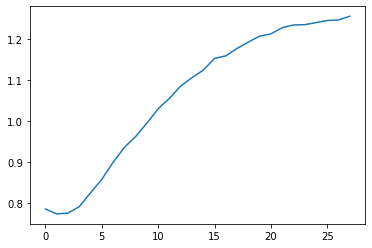

In [22]:
plt.plot(bilinear_mdl.val_losses[2:])

In [23]:
tfph = tf.compat.v1.placeholder
tfvar = tf.compat.v1.get_variable
tf.compat.v1.disable_eager_execution()
mf_mdl = MF(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, 
            movie_features = movie_features, user_features = user_features)

In [24]:
# dataset: 22M

In [25]:
mf_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])

  0%|          | 0/30 [00:00<?, ?it/s]

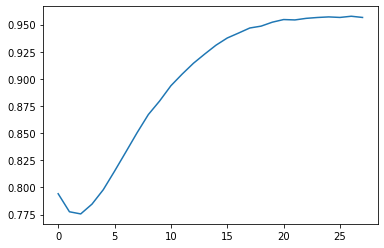

In [26]:
plt.plot(mf_mdl.val_losses[2:])

  0%|          | 0/30 [00:00<?, ?it/s]

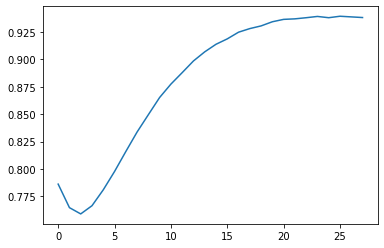

In [27]:

mf_mdl = MF(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, movie_features = movie_features, user_features = None)
mf_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])
plt.plot(mf_mdl.val_losses[2:])

  0%|          | 0/30 [00:00<?, ?it/s]

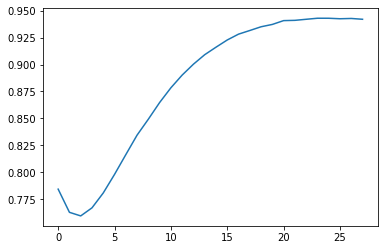

In [28]:

mf_mdl = MF(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, movie_features = movie_features, user_features = None)
mf_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])
plt.plot(mf_mdl.val_losses[2:])

  0%|          | 0/30 [00:00<?, ?it/s]

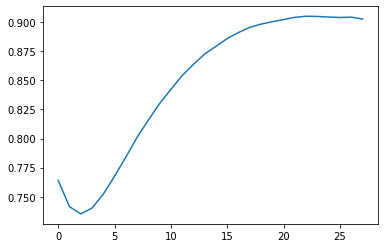

In [29]:

mf_mdl = MF(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, movie_features = None, user_features = None)
mf_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])
plt.plot(mf_mdl.val_losses[2:])

  0%|          | 0/30 [00:00<?, ?it/s]

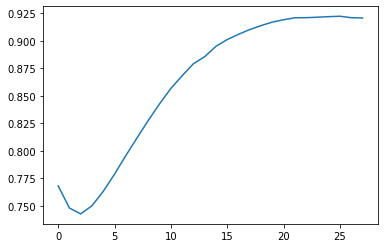

In [30]:

mf_mdl = MF(ratings_train=ratings_train, ratings_test=ratings_test, num_users=num_users, num_movies=num_movies,
            minrating=minrating, maxrating=maxrating, emb_size=64, movie_features = None, user_features = None)
mf_mdl.train(epochs = 30, batch_size = {False:2**21, True:64}[dbg])
plt.plot(mf_mdl.val_losses[2:])